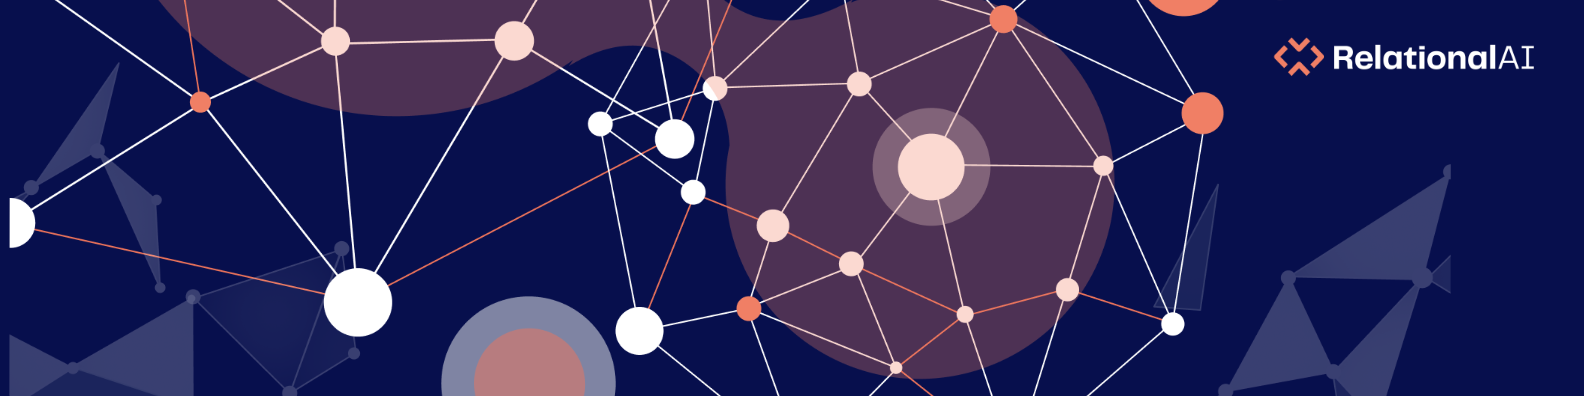 <!--Temporary solution to see the image in Github preview in private repo-->


<!-- <img src="assets/rai_banner.png"> This way Github preview should show image correctly for public repo -->


# Understanding Customer Behavior using Knowledge Graphs
Understanding customer behavior is crucial for unlocking valuable business insights that can help organizations thrive. The goal of this notebook is to demonstrate how RelationalAI, along with its deep integration with the Snowflake Data Cloud, can help you uncover user behavior patterns by running powerful graph algorithms directly on your existing Snowflake data.

We'll analyze user transactions to find groups who trade often. Then, we'll target key people in each group with ads to get them using our platform more. This can potentially generate new revenue streams and boost the overall platform engagement.

We will demonstrate how easy it is to:
- Create and visualize a graph on top of existing Snowflake data
- Enrich the graph with additional knowledge to help us group and rank our users
- Run graph algorithms to identify communities as well as influencers
***

## Let's get started!

### Importing Packages 
We start by importing all the Python packages and modules that we will need, including the `relationalai` package. We then define the `money_trail` model object. 

> **Note**. Models represent collections of objects. Objects, like Python objects, have types and properties, which we will define in a bit.

In [1]:
import os

def install_packages():
    os.system("pip install relationalai matplotlib")

install_packages()

When you first run this notebook, go to the Appendix and run the cells there to complete the data-setup steps that are required for the rest of the notebook.

In [2]:
import relationalai as rai
from relationalai.std.graphs import Graph
from relationalai import std
from relationalai.std import alias
from relationalai.std.aggregates import count, sum, max, top

import matplotlib as mpl
from typing import Tuple

model = rai.Model("money_trail")

### Importing data from Snowflake
We now can import data from the Snowflake table that contains information about transactions between users.

**Note. The Appendix at the end of this notebook has SQL code and a RelationalAI CLI invocation to create the tables in Snowflake and the data stream with RelationalAI. If no one has done those steps for your account yet, be sure to do that before proceeding.**

> **Note**. We access data in Snowflake by simply passing our table location as `source` parameter while creating a model type in the format `<my_database.my_schema.my_table>`. `Transaction`, for instance, contains the data in a database called `rai_demo`, schema `money_flow` and table `user_transactions`. 

In [3]:
Transaction = model.Type("Transaction", source="rai_demo.money_flow.user_transactions")

> **Note**.
We connect to Snowflake and create a Snowpark session using the `rai init` command. A `data stream` between the `user_transactions` table and the `money_trail` model was created to stream the data from Snowflake to the RAI schema. 

### Getting to know the input data
Let's query our transactions data to understand its shape.

First, we check what are all the properties our `Transaction` objects have using `Transaction.known_properties()`.

In [4]:
Transaction.known_properties()

['snowflake_id', 'amount', 'user2_id', 'user1_id']

> **Note**. The `snowflake_id` property is the RAI internal identifier of a row in a Snowflake table and can be ignored.

Now we can query all these properties and take a look at their values. Let's also count how many transactions we have in our data.

In [5]:
# count number of transactions
with model.query() as select:
    t = Transaction()
    response = select(alias(count(t), 'nr. transactions'))
response

In [6]:
# show first 5 transactions
with model.query() as select:
    t = Transaction()
    top(5, t)
    response = select(t.user1_id, t.user2_id, t.amount)
response

## Weaving data into the model

Our input data contains `Users` who use our platform to transfer money to each other via `Transactions`. We therefore define an additional type the concept of user.
Types are collections of objects. You create them using the `model.Type()` method, which returns an instance of the `Type` class.

Next, let’s weave our data into our model by writing a rule, that creates `Users` from `Transactions`.

In [7]:
User = model.Type("User")

with model.rule():
    t = Transaction()
    t.set(src = User.add(id=t.user1_id),
          dst = User.add(id=t.user2_id))

> **Note**.
Rules describe objects in a model and the relationships between them. They are created using the `model.rule()` context manager. We loop through our transactions table, and create a new object of type `User` for each unique occurrence of a user id in either the `user1_id` or the `user2_id` columns, using `User.add`. The combination of properties provided to `.add()` are hashed internally to provide a unique object ID to identify the object in the model.
Additionally, we set created user as `Transaction` properties: `src` (that maps to the `user1_id` column) and `dst` (that maps to the `user2_id` column).

## Visualizing the input data
Pictures speak louder than words. To better understand our input data and how the money flows between our users, let’s visualize it. We do this by defining a graph, where `Users` represent the **nodes** in our graph, and `Transactions` represent the **edges**.

In [8]:
input_graph = Graph(model)
Node, Edge = input_graph.Node, input_graph.Edge

Node.extend(User, label=User.id, hover=User.id)

with model.rule():
    t = Transaction()
    Edge.add(t.src, t.dst)

input_graph.visualize().display(inline=True)

> **Tip**.
This visualization shows us how the money flows, but does not yet provide us with insights around how connected our users are, or who is transferring the most money. Let's therefore extend our graph with additional knowledge.

## Enriching the graph with additional knowledge
While our input data is limited to people and transactions between them, we can use it to **derive additional knowledge** that will help us better understand our graph and the relationships between our users. We can then answer questions such as which nodes are the most important? Or which clusters of users facilitate money movement? Where does the money leave our platform all together?

### Knowledge gained by counting transactions
One of the most simple aggregations that we can run is the `count` aggregation. You’d be surprised how much valuable information it can provide us with! For instance, this metric could be used to identify the most active edges in the graph. These represent the most important relationships between our users, due to the frequency of transactions between them.

Let's start by checking how active our users are on our platform, by counting:
* The total number of transactions by user, where the user is either the `source` or the `destination` of the transaction (in other words, the user is the sender or the receiver of the money).
* Counting the number of transactions sent by each user.
* Counting the number of transactions received by each user.

> **Note**.
 We first create 3 rules, one to set for each user the `txn_received` property, the second one to set the `txn_sent`, and the third to `total_txn_count` properties. Notice how we need to use default values when adding relations.

In [9]:
with model.rule():
    u = User()
    t = Transaction(dst = u)
    u.set(txn_received = count(t, per = [t.dst]))

with model.rule():
    u = User()
    t = Transaction(src = u)
    u.set(txn_sent = count(t, per = [t.src]))

with model.rule():
    u = User()
    u.set(total_txn_count = u.txn_sent.or_(0) + u.txn_received.or_(0))

Let's now query the `txn_sent` and `txn_received` properties for each user.

In [10]:
with model.query() as select:
    u = User()
    top(10, u.txn_received, u)
    result = select(u.id, u.txn_sent.or_(0), u.txn_received.or_(0))
result

While it's useful to know how many transactions a user sent or received in total, we could also ask ourselves, how often did a user receive a transaction by a particular sender? If it's more than once, then that would indicate a stronger relationship between those two users than if only one transaction took place. We'll again query only the first ten rows.

In [11]:
with model.rule():
    t = Transaction()
    t.set(total_received = count(t, per=[t.dst, t.src]))

with model.query() as select:
    t = Transaction()
    top(10, t.total_received, t)
    result = select(alias(t.dst.id, 'receiver'), alias(t.src.id, 'sender'), t.total_received)
result


> **Tip**.
 There is a strong connection between user 1 and 2, 1 and 4 as well as 2 and 3, given that they had more than 1 transaction among each other.

Let's create a rule to tag edges where there was more than one transaction between two users as a `StrongConnection`. We can then use this tag in our visualizations.

> **Note**.
 We first create a new `Type` called `StrongConnection`. This type is then set on all transactions that meet the criteria we provide in the rule.

In [12]:
StrongConnection = model.Type("StrongConnection")

with model.rule():
    t = Transaction()
    t.total_received > 1
    t.set(StrongConnection)

### Visualizing Strong Connections
Now that we know how many transactions there were between users, we can use this information to visualize how strong the connection between them is.

We create a new graph, so that we can set some additional properties for visualization purposes. For instance, we mark all `StrongConnections` edges in red and set the 'size' property of edges to the transaction count. 

In [13]:
txn_ct_graph = Graph(model, weighted=True)
Node, Edge = txn_ct_graph.Node, txn_ct_graph.Edge

Node.extend(User, label=User.id)

# We clearly want to indicate strong connections and therefore set both the color and the size of those edges.
with model.rule():
    t = Transaction()
    sc = StrongConnection()
    Edge.add(t.src, t.dst, hover=t.total_received)
    Edge.add(sc.src, sc.dst, color = 'red', size=t.total_received * 3)

txn_ct_graph.visualize().display(inline=True)

> **Tip**.
This visualizations provides us already with some more insights than the previous one. We can see for example that user 2 is receiving a lot of transactions. Can we think of more data points that could help us get a better understanding of the behavior of our users?

### Identifying the most valuable relationships using the `sum` aggregation
We calculate the transaction volume as the sum of all the money that got transferred from one user to another to identify the most valuable relationships between nodes. 

Let's try to understand the full picture, by querying both the total amount sent and received, as well as the net amount. We're particularly interested in users who have received more than they have sent, let's therefore sort by the net amount. 

In [14]:
with model.rule():
    t = Transaction()
    t.set(total_volume = sum(t.amount, per=[t.src, t.dst]))

with model.rule():
    u = User()
    t = Transaction(dst = u)
    u.set(total_amt_received = sum(t.total_volume, per=[t.dst]))

with model.rule():
    u = User()
    t = Transaction(src = u)
    u.set(total_amt_sent = sum(t.total_volume, per=[t.src]))

with model.query() as select:
    u = User()
    tr = u.total_amt_received.or_(0)
    ts = u.total_amt_sent.or_(0)
    diff = ts - tr
    top(10, -diff, u)
    result = select(u.id, alias(ts, 'total amount sent'), alias(tr, 'total amt received'), alias(diff, 'net amount'))
result

Let's create a new visualization. We create a new graph, as we want to use different properties on the edge than previously. This time, the thickness of the edge depends on the transaction volume, instead of the transaction count. We again mark `StrongConnections` in red.

In [15]:
tv_graph = Graph(model, weighted=True, undirected=False)
Node, Edge = tv_graph.Node, tv_graph.Edge

Node.extend(User, label=User.id)

# We set the transaction amount as the size property of each edge
with model.rule():
    t = Transaction()
    sc = StrongConnection()
    Edge.add(t.src, t.dst, size=t.total_volume/300, hover=t.total_volume)
    Edge.add(sc.src, sc.dst, color = 'red')

tv_graph.visualize().display(inline=True)

> **Tip**.
This visualization demonstrates that the number of transactions between users don't tell us the whole story. Looking at the thick edge between user 1 and 3, we can see that there was also a one-time transaction between two users that was much larger than the amounts between our strong connections.

## Community Detection using Infomap
The `Infomap` algorithm is a powerful tool for identifying user communities within a network. Infomap analyzes user interactions to reveal clusters of users who frequently send money between each other.

By understanding user communities, we can tailor marketing campaigns to resonate with specific groups. This can significantly improve campaign effectiveness and ROI.

> **Note**.
Running a graph algorithm is as simple as creating a graph, defining its nodes and edges, and then using the graph's `.compute` object, which contains the methods for computing graph analytical functions, such as `infomap`.

In [16]:
infomap_graph = Graph(model)
Node, Edge = infomap_graph.Node, infomap_graph.Edge

Node.extend(User, label=User.id)

# We set the transaction amount as the size property of each edge
with model.rule():
    t = Transaction()
    Edge.add(t.src, t.dst, size=t.total_volume/300, hover=t.total_volume)

with model.rule():
    u = User()
    community = infomap_graph.compute.infomap(u)
    u.set(community = community)
    Node(u).set(community = community)

with model.query() as select:
    u = User()
    c = count(u, per=[u.community])
    result = select.distinct(u.community, alias(c, 'user count'))

result

> **Tip**.
The algorithm found 2 communities. Community 1 is the largest one, with 14 users who have transferred money to each other.

Let's visualize our graph and assign colors to each community, so that we can easily spot to which community each user belongs to.

In [17]:
def color_nodes(graph, by: str, cmap = mpl.cm.rainbow, default: str = "black"):
    # Normalize the values of the property `by` to [0, 1] and set
    # the `color` property` of each node to the normalized value.
    with graph.model.rule():
        node = graph.Node()
        prop = getattr(node, by)
        min_ = std.aggregates.min(prop)
        max_ = std.aggregates.max(prop)
        normalized = (prop - min_) / (max_ - min_)
        node.set(color=normalized)

    # Define a function that returns the color of a node based on
    # its `color` property. Colors are determined by the `cmap`
    # colormap. If a node does not have the `color` property,
    # the`default` color is returned.
    def _color(node):
        if node.get("color") is not None:
            return mpl.colors.to_hex(cmap(node['color']))
        else:
             return default

    return _color

infomap_graph.visualize(node_size_factor = 2, style={"node": {"color": color_nodes(infomap_graph, by="community") }}).display(inline=True)


## Detecting influential users
Centrality algorithms are useful for detecting influential users within a network. RelationalAI supports a number of different centrality algorithms, for the purpose of this demo, we're going to use the `eigenvector_centrality` algorithm. 

Depending on how we define influential users - users that use our platform a lot vs. users who have transferred a lot of money - we can either run the algorithm and use the transaction count as the weight of the graph, or the transaction volume.

When running it on a transaction count graph, the algorithm will identify the users who are most connected to other users who are themselves well connected. This is different from when running it on a transaction volume graph, where the algorithm will identify the users who are most connected to other users who are transferring the largest amounts. 

Let's use the transaction volume as our main metric.

### Detecting influential users based on transaction volume
Let's try to detect influential users based on the `txn_volume` attribute that we calculated earlier. We do this by building a new graph that is `weighted`, where the weight property of each edge is set to the total volume of the edge, meaning the total amount of money sent between two users in either direction. We then compute the `eigenvector_centrality` for every node. 

> **Tip**.
 Note that we create an undirected graph, but `txn_volume` is calculated as a total amount of money sent from one user to another in a certain direction. Therefore in order to calculate the relationship value correctly, we need to sum up `txn_volume` of two types of `Transactions` - where one user is the source and the other user is the destination, and the other way round.

In [18]:
weighted_tv_graph = Graph(model, undirected=True, weighted=True)
Node, Edge = weighted_tv_graph.Node, weighted_tv_graph.Edge

# We set the sum of the transaction volumes between two users as the weight of the edge between them
with model.rule():
    t = Transaction()
    with model.case():
        with model.not_found():
            Transaction(src=t.dst, dst=t.src)
        Edge.add(t.src, t.dst, weight=t.total_volume, size=t.total_volume/1000, hover=t.total_volume)
    with model.case():
        total_volume = t.total_volume + Transaction(src=t.dst, dst=t.src).total_volume
        Edge.add(t.src, t.dst, weight=total_volume, size=total_volume/1000, hover=total_volume)

with model.rule():
    u = User()
    Node.add(u, label=u.id, hover = u.ctr_by_tv,  community=u.community)

with model.rule():
    u = User()
    ctr_by_tv = weighted_tv_graph.compute.eigenvector_centrality(u)
    # We set the centrality as a property of the node
    Node(u).set(ctr_by_tv=ctr_by_tv, size=ctr_by_tv*200)
    u.set(ctr_by_tv=ctr_by_tv)

with model.query() as select:
    u = User()
    top(10, u.ctr_by_tv, u)
    result = select(alias(u.id, "user"), alias(u.ctr_by_tv, "eigenvector score by txn volume"))
result

### Extending visualization with eigenvector score
Let's create a final visualization, where we combine both the colors for the communities, as well as the node size based on the eigenvector score of each user based on their transaction volume.

In [19]:
weighted_tv_graph.visualize(node_size_factor = 0.75, style={"node": {"color": color_nodes(weighted_tv_graph, by="community") }}).display(inline=True)


> **Tip**.
The metric that we use to calculate the influence of a user has a significant impact on the results. For example, user 2 is the most influential user when looking at the number of transactions, but user 1 is the most influential user when looking at the transaction volume.

## Selecting Users for Targeted Campaigns
Once we've utilized RelationalAI's graph algorithms to analyze user behavior, it's time to translate those insights into action. One way to do this is to create a stored procedure that users can run from Snowflake, that returns the users with the highest eigenvector score per community. Optionally, the results of the query can be written back to a table within Snowflake.

We first create a rule that tags all the users with the highest eigenvector score (by transaction count) within their community as `HighScoringUser` and then run a query to confirm which user is our influencer by community.

In [20]:
HighScoringUser = model.Type('HighScoringUser')

with model.rule():
    u = User()
    max_score = max(u.ctr_by_tv, per=[u.community])
    u.ctr_by_tv == max_score
    u.set(HighScoringUser)


with model.query() as select:
    u = HighScoringUser()
    result = select(u.community,alias(u.id, "user"), alias(u.ctr_by_tv, "eigenvector score by txn volume"))
result

### Create stored procedure
Finally, we create a stored procedure, so that users without access to this notebook can query the highest scoring users directly from within Snowflake.

In [21]:
@model.export("rai_demo.money_flow")
def get_high_scoring_users() -> Tuple[int]:
    u = HighScoringUser()
    return u.id

# Appendix

## Inserting Data

To insert the data for this demo into Snowflake, change the value of `DO_SETUP` below to `True` and run the cell.

In [23]:
DO_SETUP = False

create_schema_commands = """
create database if not exists RAI_DEMO;
create schema if not exists RAI_DEMO.MONEY_FLOW;
"""

create_table_command = """
create or replace table RAI_DEMO.MONEY_FLOW.USER_TRANSACTIONS (
	USER1_ID NUMBER(18,0),
	USER2_ID NUMBER(18,0),
	AMOUNT NUMBER(18,0)
);
"""

insert_data_command = """
insert into RAI_DEMO.MONEY_FLOW.USER_TRANSACTIONS (USER1_ID, USER2_ID, AMOUNT) VALUES
(1,2,1766),
(1,2,338),
(1,2,504),
(1,2,504),
(1,3,4202),
(1,4,693),
(2,5,828),
(1,6,772),
(13,10,806),
(9,6,241),
(12,17,738),
(16,9,415),
(5,1,1086),
(15,12,684),
(3,2,996),
(20,3,766),
(17,15,167),
(15,3,794),
(19,12,956),
(14,12,654),
(15,14,891),
(3,14,1668),
(1,4,916),
(18,7,142),
(20,9,212),
(6,9,781),
(13,2,828),
(4,3,646),
(4,8,794),
(15,17,191),
(9,2,276),
(18,16,651),
(20,2,306),
(6,5,195),
(20,11,536),
(8,15,327),
(15,19,772),
(4,18,782),
(3,2,610),
(20,14,693),
(5,16,338);
"""

def exec_commands(resources, commands):
    for cmd in commands.split(";"):
    	if cmd.strip():
            resources._exec(cmd)

def setup():
    resources = rai.Resources()
    for commands in [
        create_schema_commands,
        create_table_command,
        insert_data_command,
    ]:
        exec_commands(resources, commands)

if DO_SETUP:
    setup()

Run the cell below to set up CDC for the table. Be sure to restart the kernel after running this cell.

In [24]:
if DO_SETUP:
    import subprocess

    command = [
        "rai", "imports:stream",
        "--source", "rai_demo.money_flow.user_transactions",
        "--model", "money_trail"
    ]

    result = subprocess.run(command)